In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.126 (2.126)	Loss 0.6952 (0.6952)	Accuracy 0.4531 (0.4531)
Batch: [10/40]	Time 0.046 (0.413)	Loss 0.5715 (0.6668)	Accuracy 0.7266 (0.5959)
Batch: [20/40]	Time 1.147 (0.411)	Loss 0.5240 (0.6312)	Accuracy 0.7500 (0.6332)
Batch: [30/40]	Time 0.288 (0.356)	Loss 0.5057 (0.6084)	Accuracy 0.7500 (0.6552)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.751 (1.751)	Loss 0.5868 (0.5868)	Accuracy 0.7266 (0.7266)
Avg validation loss: 0.5125922796726227 	 Accuracy: 0.744
--------------------
Epoch 0/20	Time 15.258 sec (15.258 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.715 (1.715)	Loss 0.4196 (0.4196)	Accuracy 0.7969 (0.7969)
Batch: [10/40]	Time 0.055 (0.420)	Loss 0.4971 (0.4779)	Accuracy 0.7109 (0.7479)
Batch: [20/40]	Time 1.188 (0.413)	Loss 0.4826 (0.4559)	Accuracy 0.7500 (0.7697)
Batch: [30/40]	Time 0.056 (0.366)	Loss 0.4372 (0.4499)	Accuracy 0.7734 (0.7734)
----------
Test: [0/4]	Time 1.694 (1.694)	Loss 0.4242 (0.4242)	Accuracy 0.8516 (0.8516)
Avg validation loss: 0.4064861171245575 	 Accuracy: 0.804
--------------------
Epoch 1/20	Time 15.414 sec (15.336 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.697 (1.697)	Loss 0.4115 (0.4115)	Accuracy 0.7891 (0.7891)
Batch: [10/40]	Time 0.165 (0.445)	Loss 0.3537 (0.3486)	Accuracy 0.8594 (0.8551)
Batch: [20/40]	Time 1.076 (0.421)	Loss 0.2096 (0.3247)	Accuracy 0.9062 (0.8597)
Batch: [30/40]	Time 0.073 (0.369)	Loss 0.2489 (0.3174)	Accuracy 0.9141 (0.8614)
----------
Test: [0/4]	Time 1.659 (1.659)	Loss 0.6089 (0.6089)	Accuracy 0.7578 (0.7578)
Avg validation loss: 0.33471478056

In [16]:
validate_encoder_classifier_epoch(test_loader, encoder, classifier,
                                 criterion, device)

Test: [0/4]	Time 2.234 (2.234)	Loss 0.0951 (0.0951)	Accuracy 0.9922 (0.9922)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.1168217567205429, 0.974)

In [17]:
import matplotlib.pyplot as plt

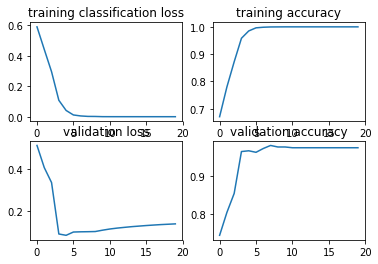

In [18]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [39]:
from synthetic_dataloader import *

In [40]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)
gender_test = GenderDataset(test_df)

In [41]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
advtest_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [42]:
encoder = LeNet()
adversary = ClassNet()

In [43]:
encoder.to(device)
adversary.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [44]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [45]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, 40):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader, encoder,
                                adversary, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, encoder, adversary,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.808 (0.808)	Loss 0.6995 (0.6995)	Accuracy 0.4766 (0.4766)
Batch: [10/40]	Time 0.033 (0.199)	Loss 0.6981 (0.6975)	Accuracy 0.4688 (0.4808)
Batch: [20/40]	Time 0.483 (0.194)	Loss 0.6936 (0.6953)	Accuracy 0.4922 (0.4911)
Batch: [30/40]	Time 0.064 (0.175)	Loss 0.6938 (0.6943)	Accuracy 0.4766 (0.4927)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.783 (0.783)	Loss 0.6919 (0.6919)	Accuracy 0.4688 (0.4688)
Avg validation loss: 0.6912885127067566 	 Accuracy: 0.48
--------------------
Epoch 0/20	Time 7.433 sec (7.433 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.874 (0.874)	Loss 0.6876 (0.6876)	Accuracy 0.5156 (0.5156)
Batch: [10/40]	Time 0.044 (0.201)	Loss 0.6936 (0.6867)	Accuracy 0.4453 (0.5199)
Batch: [20/40]	Time 0.534 (0.194)	Loss 0.6859 (0.6870)	Accuracy 0.5078 (0.5104)
Batch: [30/40]	Time 0.048 (0.176)	Loss 0.6897 (0.6865)	Accuracy 0.4375 (0.5033)
----------
Test: [0/4]	Time 0.769 (0.769)	Loss 0.6815 (0.6815)	Accuracy 0.4688 (0.4688)
Avg validation loss: 0.6819749927520752 	 Accuracy: 0.482
--------------------
Epoch 1/20	Time 7.536 sec (7.485 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.854 (0.854)	Loss 0.6831 (0.6831)	Accuracy 0.4688 (0.4688)
Batch: [10/40]	Time 0.034 (0.200)	Loss 0.6738 (0.6784)	Accuracy 0.5391 (0.5320)
Batch: [20/40]	Time 0.300 (0.189)	Loss 0.6786 (0.6777)	Accuracy 0.5000 (0.5394)
Batch: [30/40]	Time 0.391 (0.183)	Loss 0.6715 (0.6761)	Accuracy 0.6328 (0.5660)
----------
Test: [0/4]	Time 0.750 (0.750)	Loss 0.6662 (0.6662)	Accuracy 0.6484 (0.6484)
Avg validation loss: 0.6682801518440

In [46]:
validate_encoder_classifier_epoch(advtest_loader, encoder, adversary, criterion, device)

Test: [0/4]	Time 0.713 (0.713)	Loss 0.2518 (0.2518)	Accuracy 0.9297 (0.9297)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.32469597864151, 0.864)

In [47]:
import matplotlib.pyplot as plt

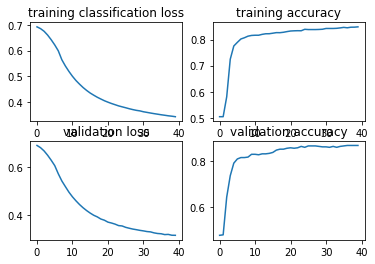

In [48]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)